# NFL 2020 Forecasting Yards Gained Using Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from modeling import *
from visualizations import *
import pickle
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Data Preprocessing

In [2]:
cols = list(pd.read_csv('Data/cleaned_nfl.csv', nrows =1))
nfl = pd.read_csv('Data/cleaned_nfl.csv',
                  usecols =[i for i in cols if i != 'Yard_class'])
nfl

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
5,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,Dee Ford,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
6,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,Terrance Mitchell,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
7,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,Phillip Gaines,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
8,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,Daniel Sorensen,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE
9,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,Marcus Peters,2017,...,1,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE


In [3]:
nfl['Defenders_vs_Distance'] = nfl['DefendersInTheBox'] / nfl['Distance']

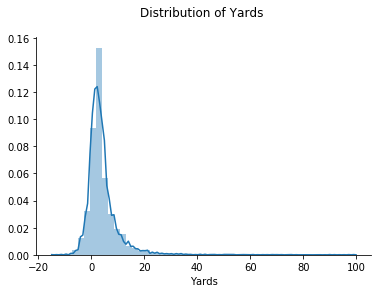

In [5]:
sns.distplot(nfl['Yards'])
sns.despine(left=False, bottom=False)
plt.title('Distribution of Yards \n')
plt.savefig('Images/Yards',
            bbox_inches='tight',
            transparent=True)

## Modeling

### Multiple Linear Regression

In [4]:
X = nfl.drop('Yards', axis=1)
y = nfl['Yards']

X = pd.get_dummies(X, drop_first=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [65]:
linreg = LinearRegression().fit(X_train, y_train)
pickle.dump(linreg, open('Models/linreg.sav', 'wb'))

In [6]:
linreg = pickle.load(open('Models/linreg.sav', 'rb'))
print('Train Score:', linreg.score(X_train, y_train))
print('Test Score:', linreg.score(X_test, y_test))
print('Intercept:', linreg.intercept_)
print('Coefficients:', linreg.coef_)

Train Score: 0.02936994299337581
Test Score: -1523718845010.9805
Intercept: -670.9833877118408
Coefficients: [-2.68888842e-04  9.86681768e-05 -1.62633126e-01 ...  1.00113992e-01
  7.04155825e-02  2.00321637e-01]


In [67]:
linreg_ols = sm.OLS(y_train,
                    sm.add_constant(X_train)).fit()

In [68]:
model_sum = linreg_ols.summary()
print(model_sum)

                            OLS Regression Results                            
Dep. Variable:                  Yards   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.037
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        00:32:03   Log-Likelihood:            -1.3321e+06
No. Observations:              407809   AIC:                         2.669e+06
Df Residuals:                  405369   BIC:                         2.696e+06
Df Model:                        2439                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [69]:
# Create a dataframe from our regression results
lin_table = linreg_ols.summary().tables[1]
lin_table = pd.DataFrame(lin_table.data)
lin_table.columns = lin_table.iloc[0]
lin_table.drop(0, inplace=True)
lin_table = lin_table.set_index(lin_table.columns[0])
lin_table = lin_table.astype(float)
lin_table.to_csv('Models/linreg.csv')
lin_table

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,-670.148500,97.230000,-6.892,0.000,-860.715000,-479.582000
long_axis,-0.000300,0.000000,-0.676,0.499,-0.001000,0.001000
short_axis,0.000100,0.001000,0.077,0.938,-0.003000,0.003000
speed,-0.162600,0.022000,-7.376,0.000,-0.206000,-0.119000
accel,0.100300,0.012000,8.529,0.000,0.077000,0.123000
Dis,0.870000,0.202000,4.298,0.000,0.473000,1.267000
Orientation,0.000050,0.000097,0.516,0.606,-0.000000,0.000000
Dir,0.000049,0.000096,0.511,0.609,-0.000000,0.000000
Season,0.365700,0.026000,14.295,0.000,0.316000,0.416000


#### Lasso

In [76]:
lin_l1 = LassoCV(cv=5, random_state=220)
lin_l1.fit(X_train, y_train)

pickle.dump(lin_l1, open('Models/lasso.sav', 'wb'))

In [77]:
lin_l1 = pickle.load(open('Models/lasso.sav', 'rb'))

print('Model Score:', lin_l1.score(X_train, y_train))
print('Intercept:', lin_l1.intercept_)
print('Coefficients:', lin_l1.coef_)

Model Score: 0.017401557078442043
Intercept: -447.52586372894166
Coefficients: [-0.00020422 -0.         -0.02233492 ... -0.         -0.
  0.        ]


#### Ridge

In [78]:
lin_l2 = RidgeCV()
lin_l2.fit(X_train, y_train)

pickle.dump(lin_l2, open('Models/ridge.sav', 'wb'))

In [79]:
lin_l2 = pickle.load(open('Models/ridge.sav', 'rb'))

print('Model Score:', lin_l2.score(X_train, y_train))
print('Intercept:', lin_l2.intercept_)
print('Coefficients:', lin_l2.coef_)

Model Score: 0.028868386879902008
Intercept: -735.5834067898729
Coefficients: [-2.77222703e-04  1.15300049e-04 -1.60641269e-01 ...  9.44893320e-02
  7.29560736e-02  2.00470512e-01]


### Random Forest Regressor

In [6]:
X = nfl.drop('Yards', axis=1)
y = nfl['Yards']

for col in X.columns:
    if X[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
    
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [11]:
rf_vanilla = RandomForestRegressor(random_state=220)
rf_vanilla.fit(X_train, y_train)
rf_vanilla.score(X_train, y_train), rf_vanilla.score(X_test, y_test)

(0.998748682337993, 0.9954792553205505)

In [6]:
rf = RandomForestRegressor(max_depth=25,
                           n_estimators=500,
                           min_samples_split=2,
                           min_samples_leaf=5,
                           max_features='sqrt',
                           random_state=220)

rf.fit(X_train, y_train)

pickle.dump(rf, open('Models/rf.sav', 'wb'))

In [9]:
rf = pickle.load(open('Models/rf.sav', 'rb'))

print('Train Score:', rf.score(X_train, y_train))
print('Test Score:', rf.score(X_test, y_test))

Train Score: 0.9362398188246017
Test Score: 0.9099051268716258


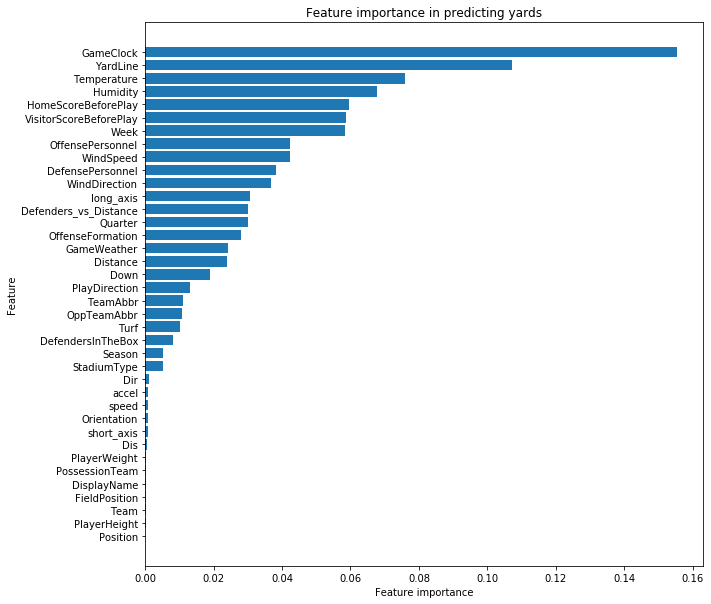

In [12]:
plot_reg_feat_imp(rf_vanilla, X);

### XGBoost Regressor

In [13]:
xgbr_vanilla = xgb.XGBRegressor(random_state=220)
xgbr_vanilla.fit(X_train, y_train)
xgbr_vanilla.score(X_train, y_train), xgbr_vanilla.score(X_test, y_test)

[13:32:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.05295510718729057, 0.05040398524467182)

In [15]:
xgbr = xgb.XGBRegressor(learning_rate=0.05,
                        max_depth=25,
                        min_child_weight=1,
                        colsample_bytree=0.979,
                        subsample=0.896,
                        random_state=220)

xgbr.fit(X_train, y_train)

pickle.dump(xgbr, open('Models/xgbr.sav', 'wb'))

[14:22:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Interpreting the Results

In [4]:
xgbr = pickle.load(open('Models/xgbr.sav', 'rb'))

[22:12:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
print('Train Score:', xgbr.score(X_train, y_train))
print('Test Score:', xgbr.score(X_test, y_test))

Train Score: 0.9996480725222343
Test Score: 0.9967552268957266


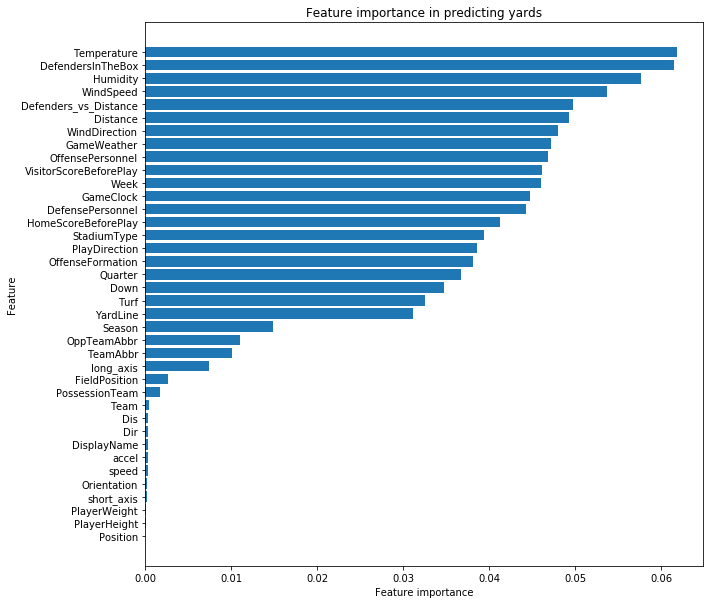

In [20]:
plot_reg_feat_imp(xgbr, X)
plt.savefig('Images/xgbr_imp.png', bbox_inches='tight');

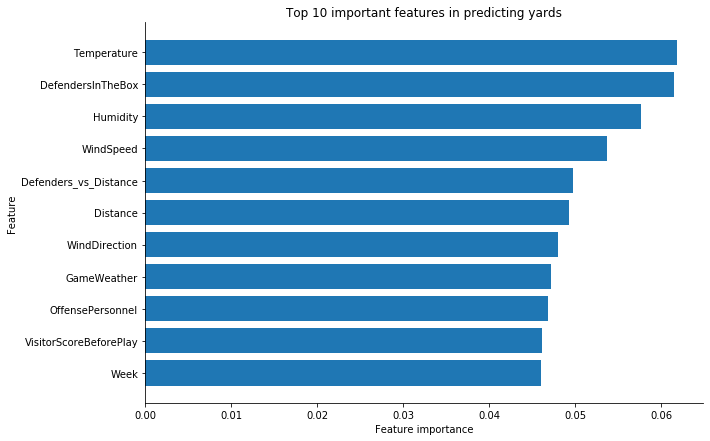

In [8]:
plot_reg_feat_imp(xgbr, X, top10=True)
sns.despine(left=False, bottom=False)
plt.savefig('Images/xgbr_imp_10.png', bbox_inches='tight');

In [33]:
Xnew = X.sample(n=3, random_state=220)
ynew = xgbr.predict(Xnew)
for i in range(len(Xnew)):
    print(Xnew.index[i], int(ynew[i]))

10678 2
358308 17
70043 0
